## Telecomunicaciones: CallMeMaybe

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats


### 1. Descripción general
Objetivo: Identificar operadores ineficaces a través de la cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes.


### 2. Analisis exploratorio de datos


In [ ]:

clients = pd.read_csv('telecom_clients_us.csv')
telecom_df= pd.read_csv('telecom_dataset_us.csv')

In [3]:
clients.info()
clients.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
690,167058,B,2019-08-29
35,166916,A,2019-08-23
28,167828,A,2019-10-02
459,167645,C,2019-09-24
623,167183,B,2019-09-05


In [4]:
telecom_df.info()
telecom_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
26727,167150,2019-11-25 00:00:00+03:00,out,True,905538.0,False,1,1,36
35930,167551,2019-09-29 00:00:00+03:00,in,False,919214.0,False,1,575,602
50705,168252,2019-11-21 00:00:00+03:00,out,False,940624.0,True,19,0,589
22380,167059,2019-11-26 00:00:00+03:00,in,False,911136.0,False,9,1114,1287
47685,168187,2019-10-28 00:00:00+03:00,in,False,937888.0,False,9,512,587


### 3. Preprocesamiento de datos



In [5]:
#verificamos duplicados
print(clients.duplicated().sum())
print(telecom_df.duplicated().sum())


0
4900


In [6]:
#verificamos valores nulos
print(clients.isna().sum())
print(telecom_df.isna().sum())

user_id        0
tariff_plan    0
date_start     0
dtype: int64
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


In [7]:
# Convertir fecha a datetime
telecom_df['date'] = pd.to_datetime(telecom_df['date'])

# Quitar duplicados 
telecom_df = telecom_df.drop_duplicates(subset=['date', 'operator_id', 'direction', 'call_duration'])

# Eliminar ausentes relevantes
telecom_df = telecom_df.dropna(subset=['operator_id', 'calls_count', 'is_missed_call', 'call_duration', 'direction'])

In [8]:
telecom_df.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
18838,166983,2019-09-20 00:00:00+03:00,out,False,901880.0,True,10,0,371
25795,167150,2019-09-19 00:00:00+03:00,out,False,905538.0,False,26,1654,2087
36839,167626,2019-10-03 00:00:00+03:00,out,False,919372.0,True,138,0,3426
8156,166658,2019-09-01 00:00:00+03:00,out,False,890404.0,True,1,0,37
20376,167002,2019-10-29 00:00:00+03:00,out,False,900492.0,True,4,0,115


### 4. Análisis de los datos

In [9]:
# Filtrar llamadas con operador asignado
calls_with_operator = telecom_df[telecom_df['operator_id'].notnull()]

# Calcular métricas generales por operador
basic_metrics = calls_with_operator.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'sum'),
    missed_call_rate=('is_missed_call', 'mean'),
    avg_call_duration=('call_duration', 'mean'),
    avg_total_duration=('total_call_duration', 'mean'))

# Redondear los resultados a dos decimales
basic_metrics = basic_metrics.round({
    'missed_call_rate': 2,
    'avg_call_duration': 2,
    'avg_total_duration': 2
})

# Ver los resultados
print(basic_metrics)


             total_calls  missed_calls  missed_call_rate  avg_call_duration  \
operator_id                                                                   
879896.0             881            40              0.36             580.56   
879898.0            7099            80              0.37            1180.69   
880020.0              35             4              0.22             124.72   
880022.0             186            24              0.37             233.03   
880026.0            2195            77              0.45             891.43   
...                  ...           ...               ...                ...   
972410.0              77             2              0.50             944.25   
972412.0              61             2              0.40             699.60   
972460.0              49             2              0.33             203.00   
973120.0               3             1              0.50               2.50   
973286.0               2             0              

In [10]:
# Filtrar solo llamadas salientes con operador
outgoing_calls = telecom_df[(telecom_df['direction'] == 'out') & (telecom_df['operator_id'].notnull())]
outgoing_by_operator = outgoing_calls.groupby('operator_id')['calls_count'].sum()

# Agregar total de llamadas salientes al dataframe
basic_metrics['total_outgoing_calls'] = outgoing_by_operator
basic_metrics['total_outgoing_calls'] = basic_metrics['total_outgoing_calls'].fillna(0)

basic_metrics.sample(5)

,total_calls,missed_calls,missed_call_rate,avg_call_duration,avg_total_duration,total_outgoing_calls
operator_id,,,,,,
952126.0,7,0,0.00,63.40,83.60,0.0
886892.0,2,0,0.00,72.00,130.00,0.0
896012.0,244,1,0.02,487.11,510.84,0.0
937772.0,1,1,1.00,0.00,18.00,1.0
945288.0,2209,18,0.50,4940.39,6072.89,2209.0


In [11]:
# Definir umbrales para considerar ineficacia
missed_threshold = basic_metrics['missed_call_rate'].quantile(0.75)
duration_threshold = basic_metrics['avg_call_duration'].quantile(0.75)
outgoing_threshold = basic_metrics['total_outgoing_calls'].quantile(0.25)

# Filtrar operadores con al menos 30 llamadas gestionadas
basic_metrics = basic_metrics[basic_metrics['total_calls'] >= 30]

# Identificar operadores que cumplen al menos 2 de los 3 criterios
basic_metrics['ineffective'] = (
    (basic_metrics['missed_call_rate'] > missed_threshold).astype(int) +
    (basic_metrics['avg_call_duration'] > duration_threshold).astype(int) +
    (basic_metrics['total_outgoing_calls'] < outgoing_threshold).astype(int)
) >= 2

# Filtrar operadores ineficaces
ineffective_operators = basic_metrics[basic_metrics['ineffective']== True]




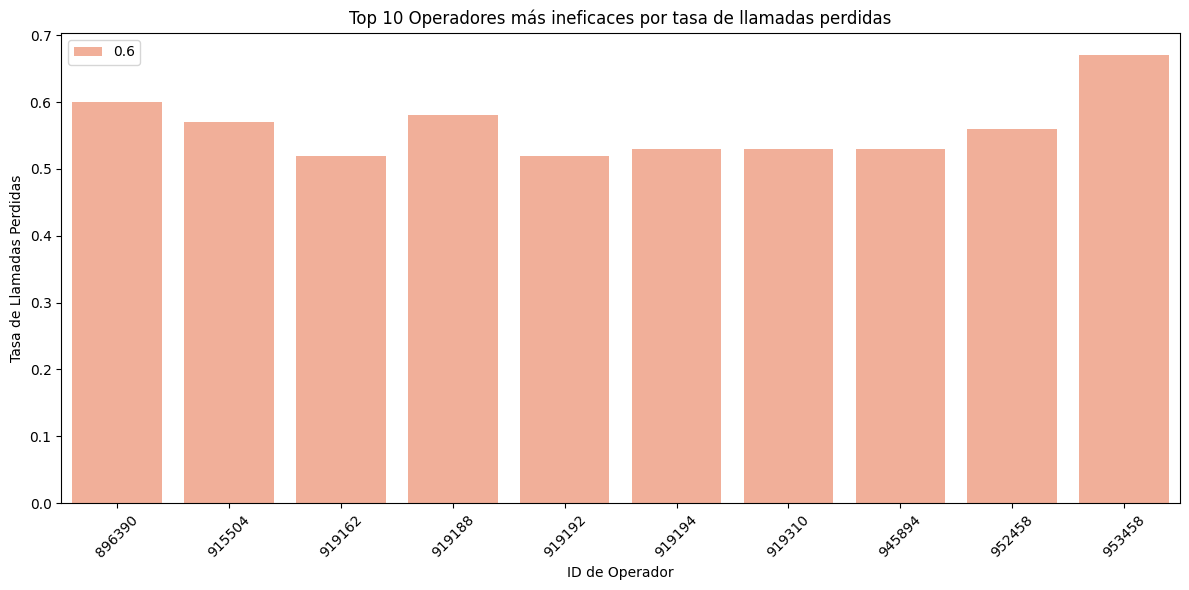

In [12]:
# Seleccionar los 10 operadores más ineficaces por tasa de llamadas perdidas
top_ineffective = ineffective_operators.sort_values(by='missed_call_rate', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_ineffective.index.astype(int),  
    y=top_ineffective['missed_call_rate'],
    palette="Reds_d", hue=0.6, saturation=0.8, alpha=0.9
)


plt.title("Top 10 Operadores más ineficaces por tasa de llamadas perdidas")
plt.xlabel("ID de Operador")
plt.ylabel("Tasa de Llamadas Perdidas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


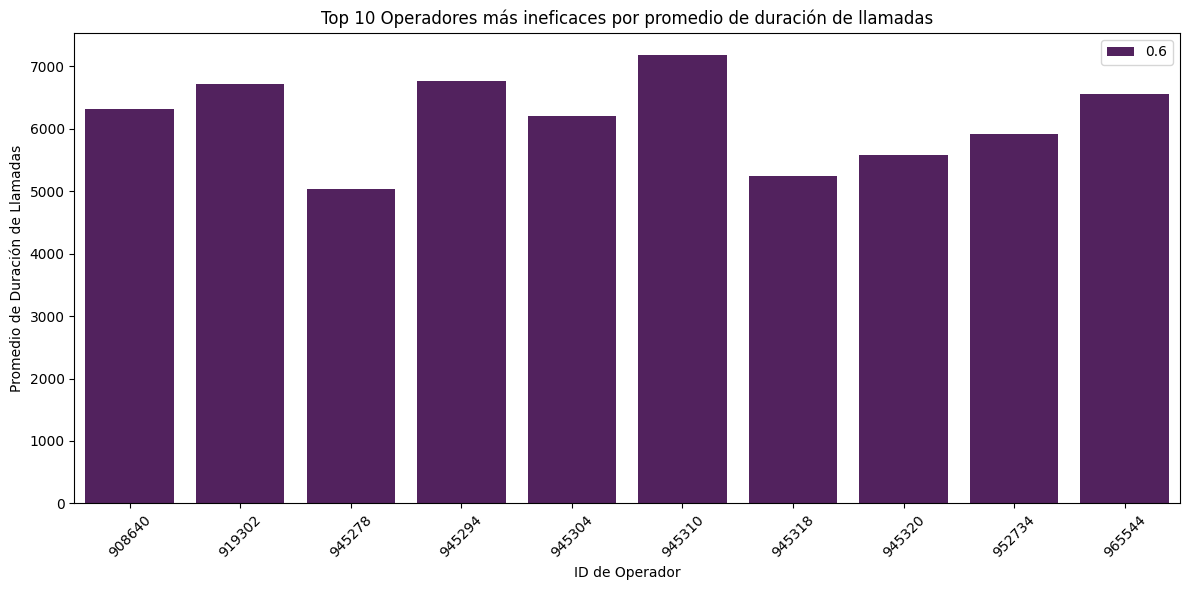

In [13]:
# Seleccionar los 10 operadores más ineficaces por promedio de duración de llamadas
top_ineffective = ineffective_operators.sort_values(by='avg_call_duration', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_ineffective.index.astype(int),  
    y=top_ineffective['avg_call_duration'],
    palette="viridis", hue=0.6, saturation=0.8, alpha=0.9
)


plt.title("Top 10 Operadores más ineficaces por promedio de duración de llamadas")
plt.xlabel("ID de Operador")
plt.ylabel("Promedio de Duración de Llamadas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observaciones: Compararemos la duracion promedio de las llamadas entre los operadores ineficaces y los demás operadores. Usaremos una prueba t de Student para ver si hay una diferencia significativa.

In [14]:
# Separar los operadores ineficaces y los demás operadores según la duración promedio de las llamadas
ineffective_operators_duration = basic_metrics[basic_metrics['ineffective'] == True]['avg_call_duration']
other_operators_duration = basic_metrics[basic_metrics['ineffective'] == False]['avg_call_duration']

# Realizar la prueba t de Student para comparar las medias de ambos grupos
t_stat, p_value = stats.ttest_ind(ineffective_operators_duration, other_operators_duration, equal_var=False)  

print(f"Estadístico t: {t_stat}, Valor p: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula de que las duraciones promedio de las llamadas de ambos grupos son iguales.")
else:
    print("No rechazamos la hipótesis nula de que las duraciones promedio de las llamadas de ambos grupos son iguales.")


Estadístico t: 13.127414610241878, Valor p: 8.856057321305416e-27
Rechazamos la hipótesis nula de que las duraciones promedio de las llamadas de ambos grupos son iguales.


Observaciones: El valor p extremadamente bajo (8.86e-27) indica que hay una diferencia altamente significativa entre las duraciones promedio de las llamadas de los operadores ineficaces y los demás operadores.
Esto sugiere que la duración de las llamadas podría ser un factor importante al evaluar la eficacia de los operadores.

### 5. Conclusiones Generales

Los operadores clasificados como ineficaces presentan una duración promedio de llamadas significativamente distinta a la de los demás operadores, según la prueba t de Student (p < 0.05).

La diferencia en duración sugiere patrones operativos diferenciados, que podrían estar relacionados con la eficiencia en la gestión de llamadas, el tipo de llamadas atendidas o la calidad del servicio ofrecido.

Todos los operadores identificados como ineficaces muestran altos valores de duración total y duración promedio de llamadas, lo que podría indicar ineficiencia operativa o casos de mal uso del tiempo de atención.

Se recomienda investigar las causas subyacentes de las largas duraciones en los operadores ineficaces, como falta de capacitación, problemas técnicos o procedimientos mal definidos

Link para visualizar el Dashboard: 
https://public.tableau.com/shared/5DJYPHMT4?:display_count=n&:origin=viz_share_link

Link para visualizar la presentacion: 
https://drive.google.com/file/d/1gl7DvDU3_eK7ZHdhCcuk0iRXWyDlRXJB/view?usp=sharing
